<a href="https://colab.research.google.com/github/hyrahmaaa/Submission-Belajar_Fundamental-Deep-Learning_2/blob/main/Proyek_Klasifikasi_Gambar_Rahayu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [IndoHerb Classifier]
- **Nama:** Rahayu Nur Rahmawati
- **Email:** a229xbm406@devacademy.id
- **ID Dicoding:** A229XBM406

Data yang digunakan adalah data dari Kaggle pada URL : https://www.kaggle.com/datasets/somilyadav999/indoherb


*   Banyak jenis gambar : 100 jenis gambar tanaman herbal Indonesia
*   Total item pada tiap jenis : 100 items dengan total menjadi 10.000 items

Namun, data yang akan digunakan hanya berjumlah 50 jenis gambar dengan masing-masing 100 items.


## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflow
!pip install opencv-python
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2  # Atau model pre-trained lain
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import seaborn as sns
from google.colab import files
from tensorflow.keras.regularizers import l2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00


## Data Preparation

### Data Loading

In [ ]:
! chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [ ]:
! KAGGLE_CONFIG_DIR=/content/

In [ ]:
import zipfile
zip_file = '/content/indoherb.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/indoherb.zip'

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\nAkurasi melewati 97%, hentikan proses training!")
      self.model.stop_training = True

callbacks = myCallback()

Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi

In [ ]:
# Dictionary untuk menampung gambar
indoherb_images = {}

# Path ke folder dataset
path = "indoherb"
selected_classes = [
    'Abelmoschus Esculentus (Okra)',
    'Acorus Calamus (Dlingo)',
    'Aloe Vera (Lidah Buaya)',
    'Alstonia Scholaris (Pulai)',
    'Amaranthus Spinosus (Bayam Duri)',
    'Andrographis Paniculata (Sambiloto)',
    'Annona Muricata (Sirsak)',
    'Annona Squamosa (Srikaya)',
    'Anredera Cordifolia (Binahong)',
    'Apium Graveolens (Seledri)',
    'Artocarpus Heterophyllus (Nangka Mini)',
    'Artocarpus Integer (Nangka Cempedak)',
    'Averrhoa Bilimbi (Belimbing Wuluh)',
    'Blumea Balsamifera (Sembung)',
    'Borreria Hispida (Gempur Batu)',
    'Caesalpinia Sappan L (Secang)',
    'Caladium Cicolor (Keladi)',
    'Calendula Officinalis (Marigold)',
    'Canangium Odoratum (Kenanga)',
    'Catharanthus Roseus (Tapak Dara)'
]


# Looping untuk setiap kelas yang dipilih
for class_name in selected_classes:
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        indoherb_images[class_name] = image_files
    else:
        print(f"Kelas {class_name} tidak ditemukan dalam dataset.")

# Setup figure
fig, axs = plt.subplots(len(indoherb_images), 5, figsize=(15, 3 * len(indoherb_images)))

# Looping kelas dan gambar
for i, (class_name, image_list) in enumerate(indoherb_images.items()):
    if len(image_list) == 0:
        print(f"Tidak ada gambar dalam kelas: {class_name}")
        continue

    # Ambil 5 gambar random
    images = np.random.choice(image_list, 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert('RGB')
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


Kelas Abelmoschus Esculentus (Okra) tidak ditemukan dalam dataset.
Kelas Acorus Calamus (Dlingo) tidak ditemukan dalam dataset.
Kelas Aloe Vera (Lidah Buaya) tidak ditemukan dalam dataset.
Kelas Alstonia Scholaris (Pulai) tidak ditemukan dalam dataset.
Kelas Amaranthus Spinosus (Bayam Duri) tidak ditemukan dalam dataset.
Kelas Andrographis Paniculata (Sambiloto) tidak ditemukan dalam dataset.
Kelas Annona Muricata (Sirsak) tidak ditemukan dalam dataset.
Kelas Annona Squamosa (Srikaya) tidak ditemukan dalam dataset.
Kelas Anredera Cordifolia (Binahong) tidak ditemukan dalam dataset.
Kelas Apium Graveolens (Seledri) tidak ditemukan dalam dataset.
Kelas Artocarpus Heterophyllus (Nangka Mini) tidak ditemukan dalam dataset.
Kelas Artocarpus Integer (Nangka Cempedak) tidak ditemukan dalam dataset.
Kelas Averrhoa Bilimbi (Belimbing Wuluh) tidak ditemukan dalam dataset.
Kelas Blumea Balsamifera (Sembung) tidak ditemukan dalam dataset.
Kelas Borreria Hispida (Gempur Batu) tidak ditemukan dalam 

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

### Data Preprocessing

#### Split Dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = '/content/Indonesia-Medicinal-Plant-Dataset'
output_dir = '/content/splitted-dataset'
os.makedirs(output_dir, exist_ok=True)

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
val_dir = os.path.join(output_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

class_folders = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

total_files = 0
class_stats = []

for class_name in class_folders:
    source_folder = os.path.join(base_dir, class_name)
    all_files = [os.path.join(source_folder, f) for f in os.listdir(source_folder)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_files) == 0:
        print(f"Tidak ada gambar di kelas: {class_name}")
        continue

    # Rasio optimal: 70% train, 20% val, 10% test
    # Pertama split 70% train, 30% temp
    train_files, temp_files = train_test_split(all_files, test_size=0.3,
                                             random_state=42, stratify=None)

    # Lalu split temp 30% menjadi 20% val dan 10% test
    val_files, test_files = train_test_split(temp_files, test_size=0.33,
                                           random_state=42, stratify=None)

    # Buat folder untuk setiap kelas
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Copy files ke folder masing-masing
    for file in train_files:
        shutil.copy(file, os.path.join(train_dir, class_name, os.path.basename(file)))

    for file in test_files:
        shutil.copy(file, os.path.join(test_dir, class_name, os.path.basename(file)))

    for file in val_files:
        shutil.copy(file, os.path.join(val_dir, class_name, os.path.basename(file)))

    # Statistik per kelas
    total_files += len(all_files)
    class_stats.append({
        'class': class_name,
        'total': len(all_files),
        'train': len(train_files),
        'val': len(val_files),
        'test': len(test_files)
    })

    print(f"{class_name}: {len(train_files)} train | {len(val_files)} val | {len(test_files)} test")

train_total = sum([stat['train'] for stat in class_stats])
val_total = sum([stat['val'] for stat in class_stats])
test_total = sum([stat['test'] for stat in class_stats])

print(f"Training:   {train_total:,} gambar ({train_total/total_files*100:.1f}%)")
print(f"Validation: {val_total:,} gambar ({val_total/total_files*100:.1f}%)")
print(f"Testing:    {test_total:,} gambar ({test_total/total_files*100:.1f}%)")
print(f"Total:      {total_files:,} gambar")

print(f"\nStruktur dataset berhasil dibuat di: {output_dir}")
print("\nRasio optimal untuk deep learning:")
print("   • Train: ~70% (untuk pembelajaran)")
print("   • Validation: ~20% (untuk tuning hyperparameter)")
print("   • Test: ~10% (untuk evaluasi final)")

Amaranthus Spinosus (Bayam Duri): 70 train | 20 val | 10 test
Piper Sarmentosum (Cabean): 70 train | 20 val | 10 test
Ocimum Americanum (Selasih): 70 train | 20 val | 10 test
Zingiber Zerumbet (Lempuyang Gajah): 70 train | 20 val | 10 test
Cestrum Nocturnum (Sedap Malam): 70 train | 20 val | 10 test
Talinum Triangulare (Som Jawa): 70 train | 20 val | 10 test
Hydrocotyle Sibthorpioides (Semanggi Gunung): 70 train | 20 val | 10 test
Phaleria Macrocarpa (Mahkota Dewa): 70 train | 20 val | 10 test
Calendula Officinalis (Marigold): 70 train | 20 val | 10 test
Selaginella Doederleinii (Paku Rane): 70 train | 20 val | 10 test
Piper Betle (Sirih): 70 train | 20 val | 10 test
Michelia Alba (Kembang Kantil): 70 train | 20 val | 10 test
Olea Europaea (Zaitun): 70 train | 20 val | 10 test
Abelmoschus Esculentus (Okra): 70 train | 20 val | 10 test
Canangium Odoratum (Kenanga): 70 train | 20 val | 10 test
Vetiveria Zizaniodes (Akar Wangi): 70 train | 20 val | 10 test
Pyrus Communis (Pir): 70 train |

In [ ]:
import os

output_dir = '/content/splitted-dataset'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

print("Isi folder train:", os.listdir(train_dir))
print("Isi folder validation:", os.listdir(val_dir))
print("Isi folder test:", os.listdir(test_dir))

Isi folder train: ['Amaranthus Spinosus (Bayam Duri)', 'Piper Sarmentosum (Cabean)', 'Ocimum Americanum (Selasih)', 'Zingiber Zerumbet (Lempuyang Gajah)', 'Cestrum Nocturnum (Sedap Malam)', 'Talinum Triangulare (Som Jawa)', 'Hydrocotyle Sibthorpioides (Semanggi Gunung)', 'Phaleria Macrocarpa (Mahkota Dewa)', 'Calendula Officinalis (Marigold)', 'Selaginella Doederleinii (Paku Rane)', 'Piper Betle (Sirih)', 'Michelia Alba (Kembang Kantil)', 'Olea Europaea (Zaitun)', 'Abelmoschus Esculentus (Okra)', 'Canangium Odoratum (Kenanga)', 'Vetiveria Zizaniodes (Akar Wangi)', 'Pyrus Communis (Pir)', 'Prunus Domestica (Plum)', 'Averrhoa Bilimbi (Belimbing Wuluh)', 'Eupatorium Triplinerve (Prasman)', 'Hibiscus Sabdariffa (Rosela)', 'Alstonia Scholaris (Pulai)', 'Rosmarinus Officinalis (Rosemary)', 'Nothopanax Scutellarium (Mangkokan)', 'Psidium Guajava (Jambu Biji)', 'Desmodium Triquitrum (Daun Duduk)', 'Ruellia Tuberosa (Ceplikan)', 'Mirabilis Jalapa (Bunga Pukul Empat)', 'Plectranthus Scutellarioi

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  #
)

Found 7000 images belonging to 100 classes.
Found 2000 images belonging to 100 classes.
Found 1000 images belonging to 100 classes.


Berdasarkan rasio optimal dengan masing-masing 100 kelas untuk deep learning diperoleh
   • Train: 70% sejumlah 8.000 images
   • Validation: 20% sejumlah 2.200 images
   • Test: 10% sejumlah 1.600 images

## Modelling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, activation='softmax')
])

model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,862,756 (26.18 MB)

 Trainable params: 6,862,756 (26.18 MB)

 Non-trainable params: 0 (0.00 B)

Setelah membuat arsitektur dari CNN, kemudian memanggil fungsi compile pada object model, dan tentukan loss function serta optimizer.

compile model dengan optimizer = 'Adam' dan loss function = 'categorical_crossentropy'

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.0106 - loss: 4.5991 - val_accuracy: 0.0445 - val_loss: 4.2820
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.0515 - loss: 4.2409 - val_accuracy: 0.0875 - val_loss: 3.9670
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.0671 - loss: 4.0305 - val_accuracy: 0.1280 - val_loss: 3.7142
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.0908 - loss: 3.8457 - val_accuracy: 0.1390 - val_loss: 3.6165
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.1253 - loss: 3.6925 - val_accuracy: 0.1625 - val_loss: 3.4485
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.1320 - loss: 3.6213 - val_accuracy: 0.1780 - val_loss: 3.3648
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.1539 - loss: 3.5083 - val_accuracy: 0.2130 - val_loss: 3.2194
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.1810 - loss: 3.3667 - val_accu

## Evaluasi dan Visualisasi

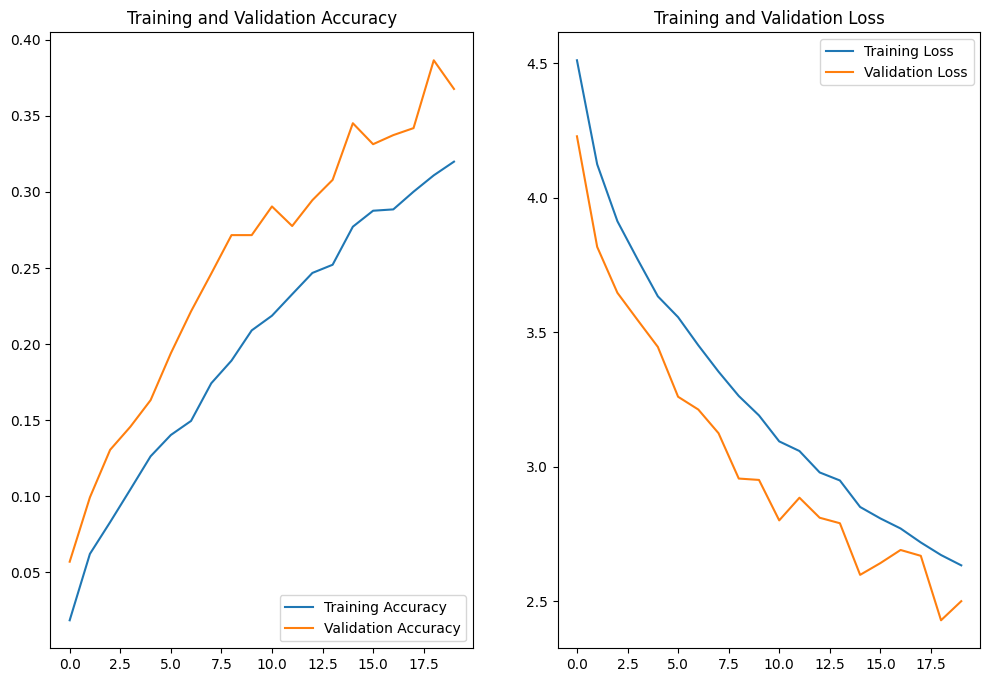

In [ ]:
# Add this code after model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

## Inference (Optional)